In [153]:
import torch
import fastai

In [154]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_trans = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.ToTensor(), 
              transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder(root = "PokemonData", transform = data_trans)

train_size = int(len(dataset) * 0.8)
dev_size = int(len(dataset) - train_size)

train_set, dev_set = random_split(dataset, [train_size, dev_size])

batchSize = 32

train_loader = DataLoader(train_set, batch_size = batchSize, shuffle = True)
dev_loader = DataLoader(dev_set, batch_size = batchSize, shuffle = False)

In [155]:
dataset.classes

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Alolan Sandslash',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur',
 'Butterfree',
 'Caterpie',
 'Chansey',
 'Charizard',
 'Charmander',
 'Charmeleon',
 'Clefable',
 'Clefairy',
 'Cloyster',
 'Cubone',
 'Dewgong',
 'Diglett',
 'Ditto',
 'Dodrio',
 'Doduo',
 'Dragonair',
 'Dragonite',
 'Dratini',
 'Drowzee',
 'Dugtrio',
 'Eevee',
 'Ekans',
 'Electabuzz',
 'Electrode',
 'Exeggcute',
 'Exeggutor',
 'Farfetchd',
 'Fearow',
 'Flareon',
 'Gastly',
 'Gengar',
 'Geodude',
 'Gloom',
 'Golbat',
 'Goldeen',
 'Golduck',
 'Golem',
 'Graveler',
 'Grimer',
 'Growlithe',
 'Gyarados',
 'Haunter',
 'Hitmonchan',
 'Hitmonlee',
 'Horsea',
 'Hypno',
 'Ivysaur',
 'Jigglypuff',
 'Jolteon',
 'Jynx',
 'Kabuto',
 'Kabutops',
 'Kadabra',
 'Kakuna',
 'Kangaskhan',
 'Kingler',
 'Koffing',
 'Krabby',
 'Lapras',
 'Lickitung',
 'Machamp',
 'Machoke',
 'Machop',
 'Magikarp',
 'Magmar',
 'Magnemite',
 'Magneton',
 'Mankey',
 'Marowak',
 '

In [156]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet101(weights="ResNet101_Weights.DEFAULT")
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Linear(512, 150, bias = True))
model = model.cuda()

In [157]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

In [158]:
print(torch.cuda.is_available())


True


In [159]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [160]:
from torch import optim
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

lr_find = LRFinder(model, optimizer, criterion, device = 'cuda')
lr_find.range_test(train_loader, end_lr=1, num_iter = 100)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.27E-01


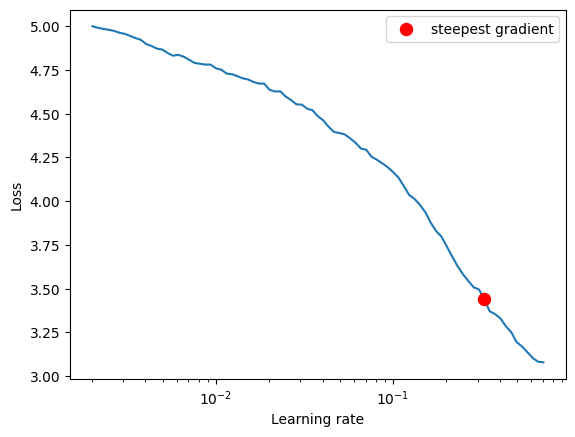

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.32745491628777273)

In [161]:
lr_find.plot()

In [162]:
optimizer = optim.Adam(model.parameters(), lr = 1.23e-02)

In [163]:
num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

       
    print(f'Epoch : {epoch + 1} Loss: {epoch_loss / len(train_loader)}')

Epoch : 1 Loss: 0.8897780422230213
Epoch : 2 Loss: 0.24849821997490543
Epoch : 3 Loss: 0.10132016183819338
Epoch : 4 Loss: 0.05320872286911945
Epoch : 5 Loss: 0.032602748043878735
Epoch : 6 Loss: 0.02908786362832227
Epoch : 7 Loss: 0.01896347277607137
Epoch : 8 Loss: 0.01923000772499986
Epoch : 9 Loss: 0.016238258496656666
Epoch : 10 Loss: 0.011722990843380273


In [164]:
torch.save(model.state_dict(), 'pokemodel.pt')

In [165]:
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1

model = models.resnet101(weights="ResNet101_Weights.DEFAULT")
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Linear(512, 150))
model.load_state_dict(torch.load('pokemodel.pt'))

<All keys matched successfully>

In [166]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
model.eval()

img_path = 'test/charmander.jpg'
img = cv2.imread(img_path)

# Convert BGR image to RGB
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert the NumPy array image to a PIL Image
cv_img = Image.fromarray(rgb_img)

# Define the same transformations used during training
data_trans = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.ToTensor(), 
              transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Preprocess the image
input_tensor = data_trans(cv_img).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Get the predicted class (you need to map class indices to Pokemon names)
predicted_class = output.argmax().item()
# Assuming 'output' is your model's output tensor
class_probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(class_probabilities, dim=1).item()


# Define the path to your dataset directory
dataset_dir = 'PokemonData'  # Replace with your dataset path

# Get a list of class names from the subfolder names
class_names = sorted(os.listdir(dataset_dir))

# Create a dictionary to map class indices to Pokemon names
class_to_name = {i: class_name for i, class_name in enumerate(class_names)}

# Now, when you have a predicted class index (predicted_class), you can get the Pokemon name
predicted_pokemon = class_to_name[predicted_class]

cv_img = np.array(img)
# Display the image with the predicted classification
cv2.putText(cv_img, f' {predicted_pokemon}', (60, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show the image with the classification
cv2.imshow('Pokemon Classification', cv_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
